# Deep Learning for Genre Classification

Let's get to it! 

First, our normal routine for setting environment variables and getting access to the OOSpotify functionality ...

In [1]:
import sys
sys.path.append('../OOSpotify/')
from OOSpotify import *

Now let's load the big dictionary we created at the end of genrePreparation.ipynb. This contains all of the track info for all of our 23 genres.

In [2]:
import pickle
genreDict = pickle.load(open('genreDict.p','rb'))

In [ ]:
np.repeat(genreDict['Alternative Rock']['trackDict'][1]['trackSegs'].loudness_max.tolist(),12).reshape(-1,12)

In [ ]:
b = genreDict['Alternative Rock']['trackDict'][1]['trackSegs']
p = np.array([i for i in b.pitches])
t = np.array([i for i in b.timbre])
l = np.repeat(b.loudness_max.tolist(),12).reshape(-1,12)
c = np.repeat(b.confidence.tolist(),12).reshape(-1,12)
print(p.shape,t.shape,l.shape,c.shape)
combo = np.dstack((p,t,l,c))
combo.shape

In [ ]:
combo[0][:2]

In [3]:
genreDict['Alternative Rock']['trackDict'][1]['trackSegs'].head()

,confidence,duration,loudness_end,loudness_max,loudness_max_time,loudness_start,pitches,start,timbre
0,1.000,0.31918,NaN,-26.553,0.20401,-60.000,"[0.039, 0.046, 0.058, 1.0, 0.04, 0.036, 0.041,...",0.00000,"[21.04, 192.807, 228.303, -180.915, 77.546, 15..."
1,0.623,0.25483,NaN,-21.271,0.09688,-28.246,"[0.402, 0.548, 0.589, 1.0, 0.848, 0.724, 0.775...",0.31918,"[35.984, 79.755, 165.445, 47.584, 33.98, 1.891..."
2,0.160,0.21546,NaN,-24.774,0.12896,-27.333,"[0.04, 0.03, 0.036, 1.0, 0.128, 0.036, 0.029, ...",0.57401,"[34.61, 47.777, 206.004, 33.644, 76.533, -25.0..."
3,0.407,0.30218,NaN,-21.818,0.03017,-25.928,"[0.243, 0.368, 0.331, 1.0, 0.334, 0.318, 0.353...",0.78948,"[35.546, 60.055, 156.861, 54.281, 40.339, -40...."
4,0.652,0.52766,NaN,-20.315,0.39887,-29.746,"[0.578, 0.948, 0.784, 1.0, 0.783, 0.684, 0.61,...",1.09166,"[35.615, 104.531, 195.808, 10.617, 38.743, -5...."


In [3]:
import numpy as np
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

def adjustMaxLen(maxlen,divisor):
    #makes the length divisible by 4
    while maxlen%divisor > 0:
        maxlen += 1
    return maxlen

def prepareData(genreDict,num_lstms=1):
    genreTimeSeries = []
    genreMetaData = []
    y = []
    for i,genre in enumerate(genreDict.keys()):
        y.append(np.ones((len(genreDict[genre]['trackList']),1))*i)
        tseries = []
        metaData = []
        for track in genreDict[genre]['trackDict']:
            segs = track['trackSegs']
            pitches = np.array([i for i in segs.pitches])
            timbres = np.array([i for i in segs.timbre])
            loudness = np.repeat(segs.loudness_max.tolist(),12).reshape(-1,12)
            durations = np.repeat(segs.duration.tolist(),12).reshape(-1,12)
            confidences = np.repeat(segs.confidence.tolist(),12).reshape(-1,12)
            series_data = np.concatenate((pitches,timbres,loudness,durations,confidences),axis=1)
            tseries.append(series_data)
            metaData.append(np.array([val for key,val in track['trackObj'].features.items()]).reshape(-1,1))
        genreTimeSeries.append(tseries)
        genreMetaData.append(metaData)
        print('Finished {}'.format(genre))
    maxlen = max([max([song.shape[0] for song in genre]) for genre in genreTimeSeries])
    maxlen_adj = adjustMaxLen(maxlen,num_lstms)
    padded = [pad_sequences(i,maxlen=maxlen_adj) for i in genreTimeSeries]
    X = np.concatenate(padded)
    Xaux = np.concatenate(genreMetaData)
    print('X Shape:',X.shape)
    print('Xaux Shape:',Xaux.shape)
    y_cat = np.concatenate(y)
    y_cat = to_categorical(y_cat)
    print('Y Shape:',y_cat.shape)
    
    #scales values to between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X_minmax = min_max_scaler.fit_transform(X.reshape((-1,60))).reshape((X.shape))
    
    aux_min_max_scaler = preprocessing.MinMaxScaler()
    Xaux_minmax = aux_min_max_scaler.fit_transform(Xaux.reshape(-1,12))
    
    X_train, X_test,y_train, y_test = train_test_split(X_minmax, y_cat, test_size=0.1,random_state=42)
    Xaux_train, Xaux_test,y_train1, y_test1 = train_test_split(Xaux_minmax, y_cat, test_size=0.1,random_state=42)
    
    print('X_train Shape:',X_train.shape)
    print('X_test Shape:',X_test.shape)
    print('Xaux_train Shape:',Xaux_train.shape)
    print('Xaux_test Shape:',Xaux_test.shape)
    return [X_train,X_test,Xaux_train,Xaux_test,y_train,y_test],[min_max_scaler,aux_min_max_scaler]

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
[X_train,X_test,Xaux_train,Xaux_test,y_train,y_test],[min_max_scaler,aux_min_max_scaler] = prepareData(genreDict)

Finished Alternative Rock
Finished Bluegrass
Finished Blues
Finished Classical
Finished Country
Finished Dubstep
Finished EDM
Finished Electronic
Finished Emo
Finished Folk
Finished Gospel
Finished Grunge
Finished Hip Hop
Finished Indie Rock
Finished Jazz
Finished Metal
Finished Motown
Finished Pop
Finished Rap
Finished Reggae
Finished Rock
Finished Ska Punk
Finished Soundtrack
X Shape: (13363, 4163, 60)
Xaux Shape: (13363, 12, 1)
Y Shape: (13363, 23)


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


X_train Shape: (12026, 4163, 60)
X_test Shape: (1337, 4163, 60)
Xaux_train Shape: (12026, 12)
Xaux_test Shape: (1337, 12)


In [8]:
from keras.layers import Input, LSTM, Dense
from keras.models import Model

num_classes = y_train.shape[1]
main_input = Input(shape=(X_train.shape[1:]), name='main_input')

# A RNN will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(main_input)
auxiliary_output = Dense(num_classes, activation='softmax', name='aux_output')(lstm_out)

auxiliary_input = Input(shape=(12,), name='aux_input')

x = keras.layers.concatenate([lstm_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(num_classes, activation='softmax', name='main_output')(x)

In [ ]:
from keras.utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint, CSVLogger
model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

# Replicates `model` on 4 GPUs.
# This assumes that your machine has 4 available GPUs.
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(optimizer='adam', loss='categorical_crossentropy',
              loss_weights=[1., 0.2],metrics=['accuracy'])
mc = ModelCheckpoint('bs32_minmaxscaled.{epoch:02d}--{val_loss:.2f}.hdf5',save_best_only=True)
csv_logger=CSVLogger('training_bs32_minmaxscaled.log')
history = parallel_model.fit([X_train[:12000], Xaux_train[:12000]], [y_train[:12000], y_train[:12000]],validation_data=([X_test,Xaux_test.reshape(-1,12)],[y_test,y_test]),
          epochs=50, batch_size=32,callbacks = [mc,csv_logger])
pickle.dump(history.history,open('training_history_bs32_minmaxscaled.p','wb'))

Train on 12000 samples, validate on 1337 samples
Epoch 1/50
12000/12000 [==============================] - 2970s 248ms/step - loss: 3.1108 - main_output_loss: 2.5133 - aux_output_loss: 2.9875 - main_output_acc: 0.2054 - aux_output_acc: 0.1053 - val_loss: 2.6942 - val_main_output_loss: 2.1215 - val_aux_output_loss: 2.8634 - val_main_output_acc: 0.3059 - val_aux_output_acc: 0.1346
Epoch 2/50
12000/12000 [==============================] - 2995s 250ms/step - loss: 2.6465 - main_output_loss: 2.0738 - aux_output_loss: 2.8636 - main_output_acc: 0.3072 - aux_output_acc: 0.1270 - val_loss: 2.5823 - val_main_output_loss: 2.0056 - val_aux_output_loss: 2.8837 - val_main_output_acc: 0.3470 - val_aux_output_acc: 0.1249
Epoch 3/50
  448/12000 [>.............................] - ETA: 46:48 - loss: 2.4946 - main_output_loss: 1.9301 - aux_output_loss: 2.8226 - main_output_acc: 0.3616 - aux_output_acc: 0.1451

In [14]:
import numpy as np
genreTimeSeries = []
genreMetaData = []
y = []
for i,genre in enumerate(genreDict.keys()):
    y.append(np.ones((len(genreDict[genre]['trackList']),1))*i)
    tseries = []
    metaData = []
    for track in genreDict[genre]['trackDict']:
        segs = track['trackSegs']
        pitches = np.array([i for i in segs.pitches])
        timbres = np.array([i for i in segs.timbre])
        loudness = np.repeat(segs.loudness_max.tolist(),12).reshape(-1,12)
        durations = np.repeat(segs.duration.tolist(),12).reshape(-1,12)
        confidences = np.repeat(segs.confidence.tolist(),12).reshape(-1,12)
        series_data = np.concatenate((pitches,timbres,loudness,durations,confidences),axis=1)
        tseries.append(series_data)
        metaData.append(np.array([val for key,val in track['trackObj'].features.items()]).reshape(-1,1))
        
        
    genreTimeSeries.append(tseries)
    genreMetaData.append(metaData)
    print('Finished {}'.format(genre))


Finished Alternative Rock
Finished Bluegrass
Finished Blues
Finished Classical
Finished Country
Finished Dubstep
Finished EDM
Finished Electronic
Finished Emo
Finished Folk
Finished Gospel
Finished Grunge
Finished Hip Hop
Finished Indie Rock
Finished Jazz
Finished Metal
Finished Motown
Finished Pop
Finished Rap
Finished Reggae
Finished Rock
Finished Ska Punk
Finished Soundtrack


In [27]:
timbres.min()

-287.654

In [5]:
import keras
from keras.preprocessing.sequence import pad_sequences
maxlen = max([max([song.shape[0] for song in genre]) for genre in genreTimeSeries])
padded = [pad_sequences(i,maxlen=maxlen) for i in genreTimeSeries]
X = np.concatenate(padded)
X_aux = np.concatenate(genreMetaData)
print(X.shape,X_aux.shape)

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(13363, 4163, 60) (13363, 12, 1)


In [4]:
from keras.utils.np_utils import to_categorical
y_cat = np.concatenate(y)
y_cat = to_categorical(y_cat)
num_classes = y_cat.shape[1]
y_cat.shape

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(13363, 23)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y_cat, test_size=0.1,random_state=42)
Xaux_train, Xaux_test,y_train1, y_test1 = train_test_split(X_aux, y_cat, test_size=0.1,random_state=42)
print(X_train.shape,X_test.shape)
print(Xaux_train.shape,Xaux_test.shape)

(12026, 4163, 60) (1337, 4163, 60)
(12026, 12, 1) (1337, 12, 1)


In [11]:
print(np.array_equal(y_train,y_train1))

True


In [8]:
from keras.layers import Input, LSTM, Dense
from keras.models import Model


main_input = Input(shape=(X_train.shape[1:]), name='main_input')

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(main_input)
auxiliary_output = Dense(num_classes, activation='softmax', name='aux_output')(lstm_out)

auxiliary_input = Input(shape=(12,), name='aux_input')

x = keras.layers.concatenate([lstm_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(num_classes, activation='softmax', name='main_output')(x)

In [ ]:
model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

In [ ]:
from keras.utils import multi_gpu_model

model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

# Replicates `model` on 4 GPUs.
# This assumes that your machine has 4 available GPUs.
parallel_model = multi_gpu_model(model, gpus=4)

In [ ]:
parallel_model.compile(optimizer='adam', loss='categorical_crossentropy',
              loss_weights=[1., 0.2],metrics=['accuracy'])

In [ ]:
history = parallel_model.fit([X_train, Xaux_train.reshape(-1,12)], [y_train, y_train],validation_data=([X_test,Xaux_test.reshape(-1,12)],[y_test,y_test]),
          epochs=10, batch_size=32)

In [26]:
def plotHistory(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['main_output_acc'])
    plt.plot(history.history['val_main_output_acc'])
    plt.plot(history.history['aux_output_acc'])
    plt.plot(history.history['val_aux_output_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val','train_aux','val_aux'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['main_output_loss'])
    plt.plot(history.history['aux_output_loss'])
    plt.plot(history.history['val_main_output_loss'])
    plt.plot(history.history['val_aux_output_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val','train_main','train_aux','val_main','val_aux'], loc='upper left')
    plt.show()
plotHistory(history)

NameError: name 'history' is not defined

In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

In [29]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

normalizing features
training on small segments of each song and averaging result (5 lstms for 5 song sections)
balancing genre classes
changing hyperparameters, learning rate scheduling
removing aux loss
training with only sequence data
training with only metadata
changing lstm to rnn or temporal conv

using sequence data to predict metatdata

In [ ]:
os.mkdir('trainH')
with open('trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [24]:
from keras.layers import Input, LSTM, Dense
from keras.models import Model


main_input = Input(shape=(X_train.shape[1:]), name='main_input')

# A RNN will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(main_input)
auxiliary_output = Dense(num_classes, activation='softmax', name='aux_output')(lstm_out)

auxiliary_input = Input(shape=(12,), name='aux_input')

x = keras.layers.concatenate([lstm_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(num_classes, activation='softmax', name='main_output')(x)

In [26]:
from keras.utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint, CSVLogger
model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

# Replicates `model` on 4 GPUs.
# This assumes that your machine has 4 available GPUs.
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(optimizer='adam', loss='categorical_crossentropy',
              loss_weights=[1., 0.2],metrics=['accuracy'])
mc = ModelCheckpoint('weights.{epoch:02d}--{val_loss:.2f}.hdf5',save_best_only=True)
csv_logger=CSVLogger('training.log')
history = parallel_model.fit([X_train, Xaux_train.reshape(-1,12)], [y_train, y_train],validation_data=([X_test,Xaux_test.reshape(-1,12)],[y_test,y_test]),
          epochs=50, batch_size=7,callbacks = [mc,csv_logger])
pickle.dump(history,open(''))

Train on 12026 samples, validate on 1337 samples
Epoch 1/50
12026/12026 [==============================] - 16549s 1s/step - loss: 3.3898 - main_output_loss: 2.8021 - aux_output_loss: 2.9385 - main_output_acc: 0.1525 - aux_output_acc: 0.1229 - val_loss: 2.9153 - val_main_output_loss: 2.3743 - val_aux_output_loss: 2.7050 - val_main_output_acc: 0.2326 - val_aux_output_acc: 0.1773
Epoch 2/50
12026/12026 [==============================] - 16399s 1s/step - loss: 2.8743 - main_output_loss: 2.3494 - aux_output_loss: 2.6244 - main_output_acc: 0.2365 - aux_output_acc: 0.1871 - val_loss: 2.6787 - val_main_output_loss: 2.1808 - val_aux_output_loss: 2.4895 - val_main_output_acc: 0.2969 - val_aux_output_acc: 0.2191
Epoch 3/50
12026/12026 [==============================] - 16379s 1s/step - loss: 2.6527 - main_output_loss: 2.1505 - aux_output_loss: 2.5111 - main_output_acc: 0.2870 - aux_output_acc: 0.2135 - val_loss: 2.4966 - val_main_output_loss: 2.0067 - val_aux_output_loss: 2.4496 - val_main_output

KeyboardInterrupt: 

In [10]:
from keras.utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint, CSVLogger
model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

# Replicates `model` on 4 GPUs.
# This assumes that your machine has 4 available GPUs.
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(optimizer='adam', loss='categorical_crossentropy',
              loss_weights=[1., 0.2],metrics=['accuracy'])
mc = ModelCheckpoint('bs60.{epoch:02d}--{val_loss:.2f}.hdf5',save_best_only=True)
csv_logger=CSVLogger('training_bs60.log')
history = parallel_model.fit([X_train[:12000], Xaux_train[:12000].reshape(-1,12)], [y_train[:12000], y_train[:12000]],validation_data=([X_test,Xaux_test.reshape(-1,12)],[y_test,y_test]),
          epochs=50, batch_size=60,callbacks = [mc,csv_logger])
pickle.dump(history.history,open('training_history_bs60.p','wb'))

Train on 12000 samples, validate on 1337 samples
Epoch 1/50
12000/12000 [==============================] - 1611s 134ms/step - loss: 3.8111 - main_output_loss: 3.1894 - aux_output_loss: 3.1088 - main_output_acc: 0.1177 - aux_output_acc: 0.0733 - val_loss: 3.4158 - val_main_output_loss: 2.8156 - val_aux_output_loss: 3.0011 - val_main_output_acc: 0.1436 - val_aux_output_acc: 0.1070
Epoch 2/50
12000/12000 [==============================] - 1626s 136ms/step - loss: 3.2645 - main_output_loss: 2.6832 - aux_output_loss: 2.9064 - main_output_acc: 0.1756 - aux_output_acc: 0.1228 - val_loss: 3.1295 - val_main_output_loss: 2.5638 - val_aux_output_loss: 2.8283 - val_main_output_acc: 0.1922 - val_aux_output_acc: 0.1436
Epoch 3/50
12000/12000 [==============================] - 1629s 136ms/step - loss: 3.0233 - main_output_loss: 2.4749 - aux_output_loss: 2.7419 - main_output_acc: 0.2204 - aux_output_acc: 0.1676 - val_loss: 2.9129 - val_main_output_loss: 2.3784 - val_aux_output_loss: 2.6725 - val_main_

Epoch 50/50
12000/12000 [==============================] - 1614s 134ms/step - loss: 1.8985 - main_output_loss: 1.5319 - aux_output_loss: 1.8328 - main_output_acc: 0.4714 - aux_output_acc: 0.3942 - val_loss: 2.0234 - val_main_output_loss: 1.6459 - val_aux_output_loss: 1.8878 - val_main_output_acc: 0.4458 - val_aux_output_acc: 0.3829


In [15]:
np.save('X_train.npy',X_train)
np.save('Xaux_train.npy',Xaux_train)
np.save('X_test.npy',X_test)
np.save('Xaux_test.npy',Xaux_test)
np.save('y_train.npy',y_train)
np.save('y_test.npy',y_test)

In [16]:
s = np.load('X_train.npy')

In [18]:
from keras.models import load_model
m = load_model('bs60.48--2.01.hdf5')

In [31]:
metrics = m.evaluate([X_test,Xaux_test.reshape(-1,12)],[y_test,y_test])

1337/1337 [==============================] - 391s 293ms/step


In [32]:
metrics

[2.0070516043130193,
 1.620879804276671,
 1.9308589887690348,
 0.44801795108156056,
 0.3649962599275713]

In [35]:
preds = m.predict([X_test,Xaux_test.reshape(-1,12)])

In [42]:
preds[0].shape

(1337, 23)

In [39]:
preds_class = [np.argmax(i) for i in preds[0]]

In [46]:
y_class = [np.argmax(i) for i in y_test]

In [49]:
preds_class[0]

8

In [50]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_class, preds_class)

In [53]:
genreList = pickle.load(open('genreList.p','rb'))
[i for i in genreList]

['Alternative Rock',
 'Bluegrass',
 'Blues',
 'Classical',
 'Country',
 'Dubstep',
 'EDM',
 'Electronic',
 'Emo',
 'Folk',
 'Gospel',
 'Grunge',
 'Hip Hop',
 'Indie Rock',
 'Jazz',
 'Metal',
 'Motown',
 'Pop',
 'Rap',
 'Reggae',
 'Rock',
 'Ska Punk',
 'Soundtrack']

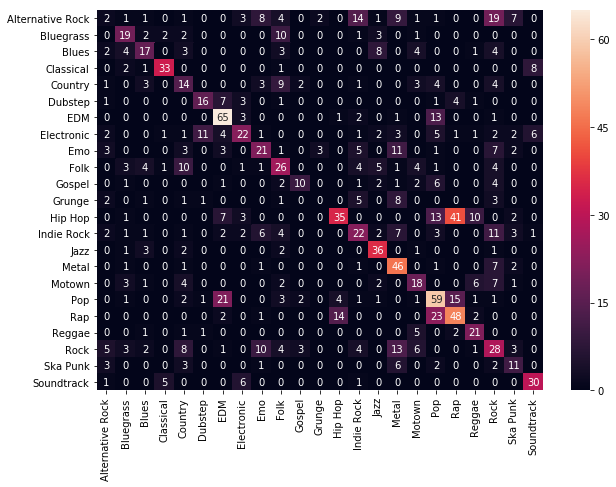

In [57]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in genreList],
                  columns = [i for i in genreList])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [81]:
y_train_class = [np.argmax(i) for i in y_train]
unique, counts = np.unique(y_train_class, return_counts=True)
for u,c in zip(unique,counts):
    print('{}: {} -> {:.1f}%'.format(genreList[u],c,(c/len(y_train_class))*100))

Alternative Rock: 648 -> 5.4%
Bluegrass: 322 -> 2.7%
Blues: 405 -> 3.4%
Classical: 469 -> 3.9%
Country: 487 -> 4.0%
Dubstep: 278 -> 2.3%
EDM: 702 -> 5.8%
Electronic: 443 -> 3.7%
Emo: 569 -> 4.7%
Folk: 540 -> 4.5%
Gospel: 318 -> 2.6%
Grunge: 259 -> 2.2%
Hip Hop: 893 -> 7.4%
Indie Rock: 759 -> 6.3%
Jazz: 349 -> 2.9%
Metal: 534 -> 4.4%
Motown: 443 -> 3.7%
Pop: 975 -> 8.1%
Rap: 753 -> 6.3%
Reggae: 377 -> 3.1%
Rock: 836 -> 7.0%
Ska Punk: 309 -> 2.6%
Soundtrack: 358 -> 3.0%


In [80]:
100*1/23

4.3478260869565215

In [82]:
from sklearn.metrics import f1_score
f1_score(y_class, preds_class, average='macro')  

0.43104612372779405

In [85]:
f1_score(y_class, preds_class, average='weighted')  

0.4321169070976944

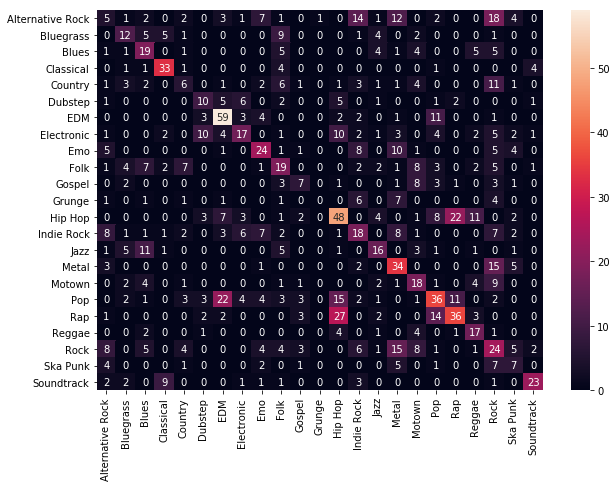

In [86]:
#auxiliary confusion matrix
predsaux_class = [np.argmax(i) for i in preds[1]]
cm = confusion_matrix(y_class, predsaux_class)
df_cm = pd.DataFrame(cm, index = [i for i in genreList],
                  columns = [i for i in genreList])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [95]:
type(history.history)

dict

In [96]:
pickle.dump(history.history,open('training_history_bs60.p','wb'))

In [99]:
X_train.shape

(12026, 4163, 60)

In [118]:
(maxlen+1)%4

0

In [4]:
from keras.utils.np_utils import to_categorical
y_cat = np.concatenate(y)
y_cat = to_categorical(y_cat)
num_classes = y_cat.shape[1]
y_cat.shape

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(13363, 23)

In [5]:
def adjustMaxLen(maxlen,divisor):
    #makes the length divisible by 4
    while maxlen%divisor > 0:
        maxlen += 1
    return maxlen

In [6]:
import keras
from keras.preprocessing.sequence import pad_sequences
maxlen = max([max([song.shape[0] for song in genre]) for genre in genreTimeSeries])
num_segments = 4
maxlen_adj = adjustMaxLen(maxlen,num_segments)
padded = [pad_sequences(i,maxlen=maxlen_adj) for i in genreTimeSeries]
X = np.concatenate(padded)
X_aux = np.concatenate(genreMetaData)
print(X.shape,X_aux.shape)

(13363, 4164, 60) (13363, 12, 1)


In [7]:
np.save('x.npy',X)
np.save('x_aux.npy',X_aux)
np.save('y.npy',y_cat)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y_cat, test_size=0.1,random_state=42)
Xaux_train, Xaux_test,y_train1, y_test1 = train_test_split(X_aux, y_cat, test_size=0.1,random_state=42)
print(X_train.shape,X_test.shape)
print(Xaux_train.shape,Xaux_test.shape)

(12026, 4164, 60) (1337, 4164, 60)
(12026, 12, 1) (1337, 12, 1)


In [8]:
X_train.shape

(12026, 4164, 60)

In [9]:
from keras.layers import Input, LSTM, Dense,Lambda
from keras.models import Model


main_input = Input(shape=(X_train.shape[1:]), name='main_input')

# A RNN will transform the vector sequence into a single vector,
# containing information about the entire sequence
num_segments = 4
maxlen_adj = adjustMaxLen(maxlen,num_segments)
start = 0
step = maxlen_adj//num_segments
lstm_aux = []
lstm_out = []
for i in range(num_segments):
    l = Lambda(lambda x: x[start:start+step,:])(main_input)
    l = LSTM(32)(l)
    l = Dense(64,activation='relu')(l)
    lstm_aux.append(Dense(num_classes,activation='softmax')(l))
    lstm_out.append(l)
    start += step

auxiliary_output = keras.layers.Average()(lstm_aux)


auxiliary_input = Input(shape=(12,), name='aux_input')
lstm_out = keras.layers.Average()(lstm_out)
x = keras.layers.concatenate([lstm_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(num_classes, activation='softmax', name='main_output')(x)

In [ ]:
from keras.utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint, CSVLogger
model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

# Replicates `model` on 4 GPUs.
# This assumes that your machine has 4 available GPUs.
parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(optimizer='adam', loss='categorical_crossentropy',
              loss_weights=[1., 0.2],metrics=['accuracy'])
mc = ModelCheckpoint('4lstm.{epoch:02d}--{val_loss:.2f}.hdf5',save_best_only=True)
csv_logger=CSVLogger('training_4lstm.log')
history = parallel_model.fit([X_train[:12000], Xaux_train[:12000].reshape(-1,12)], [y_train[:12000], y_train[:12000]],validation_data=([X_test,Xaux_test.reshape(-1,12)],[y_test,y_test]),
          epochs=50, batch_size=60,callbacks = [mc,csv_logger])
pickle.dump(history.history,open('training_history_4lstm.p','wb'))

Train on 12000 samples, validate on 1337 samples
Epoch 1/50


Tried doing the slicing as a lambda layer within the model, but was having hard to deal with errors. 

In [10]:
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
# define contrived series
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
series = Series(data)
print(series)
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print
normalized = scaler.transform(values)
print(normalized)
# inverse transform and print
inversed = scaler.inverse_transform(normalized)
print(inversed)

0     10.0
1     20.0
2     30.0
3     40.0
4     50.0
5     60.0
6     70.0
7     80.0
8     90.0
9    100.0
dtype: float64
Min: 10.000000, Max: 200.000000
[[0.        ]
 [0.11111111]
 [0.22222222]
 [0.33333333]
 [0.44444444]
 [0.55555556]
 [0.66666667]
 [0.77777778]
 [0.88888889]
 [1.        ]]
[[ 10.]
 [ 20.]
 [ 30.]
 [ 40.]
 [ 50.]
 [ 60.]
 [ 70.]
 [ 80.]
 [ 90.]
 [100.]]


In [11]:
X_train

NameError: name 'X_train' is not defined